# Twitter API notebook

This uses the Twython API to fetch the latest tweets from my own twitter feed.
It creates a dataframe of raw data (including the text that the tweet links to).
Then displays an example graph.

In [1]:
import configparser
from twython import Twython
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

In [2]:
config = configparser.ConfigParser()
config.read('twitter_tokens.cfg')

# spin up twitter api
APP_KEY    = config.get('credentials','app_key')
APP_SECRET = config.get('credentials','app_secret')
OAUTH_TOKEN        = config.get('credentials','oath_token')
OAUTH_TOKEN_SECRET = config.get('credentials','oath_token_secret')
 
twitter = Twython(APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
# twitter.verify_credentials()

In [3]:
# Fetch most recent posts
params = {'count':20, 'contributor_details':False, 'exclude_replies':True}
home = twitter.get_home_timeline(**params)

# Get the posts that the user has favorited
liked_posts = twitter.get_favorites(**params)
liked_list_ids = [liked_posts[i]['id_str'] for i in range(len(liked_posts))]

In [4]:
def get_linked_text(url):
    # url = home[5]['entities']['urls'][0]['expanded_url']
    req = requests.get(url)
    source = req.text
    soup = BeautifulSoup(source, 'html.parser')
    body = soup.text

    # clean the body
    clean_body = ' '.join(re.sub("(</[a-zA-Z]>)|(<[a-zA-Z]>)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", body).split())

    return clean_body

In [6]:
data_dict = {'names':[], 'locs':[], 'tweet_texts':[], 'links':[], 'linked_text':[], 'liked':[]}
for post in home:
    # Get the URLs
    try:
        link = post['entities']['urls'][0]['expanded_url']
        linked_text = get_linked_text(link)
    except:
        link = None
        linked_text = None
    
    if post['id_str'] in liked_list_ids:
        liked = 1
    else:
        liked = 0

    post_dict = {'names':[post['user']['name']], 'locs':[post['user']['location']], 'tweet_texts':[post['text']], 'links':[link], 'linked_text':[linked_text], 'liked':[liked]}

    data_dict = {key: value + post_dict[key] for key, value in data_dict.items()}

# Save to a pandas dataframe
raw_data = pd.DataFrame(data = data_dict)
raw_data.head(3)

,names,locs,tweet_texts,links,linked_text,liked
0,National Geographic,Global,Wildlife rangers bid their last farewell to th...,https://twitter.com/i/web/status/1370410590787...,JavaScript is not available We ve detected tha...,0
1,The Guardian,London,Royal Mail to trial Sunday parcel service for ...,https://www.theguardian.com/business/2021/mar/...,Royal Mail to trial Sunday parcel service for ...,0
2,BBC News (World),"London, UK",The 'battle tactics' used in crackdowns on Mya...,https://bbc.in/3l7ZUWn,Myanmar coup The battle tactics used in crackd...,0


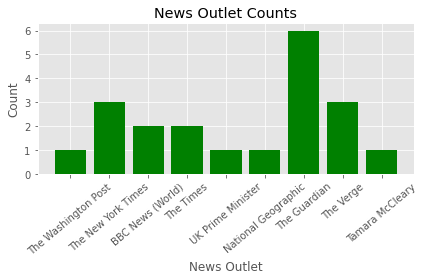

In [7]:
# Create Example Graph
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib inline
plt.style.use('ggplot')

x = list(set(raw_data['names']))
count = [list(raw_data['names']).count(i) for i in list(set(raw_data['names']))]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count, color='green')
plt.xlabel("News Outlet")
plt.ylabel("Count")
plt.title("News Outlet Counts")

plt.xticks(x_pos, x, rotation=40)


plt.tight_layout()
plt.savefig('news_outlets.jpg')
plt.show()


<Figure size 432x288 with 0 Axes>